# This part performs the LSTM + TFIDF part of the project.

## The following are  the parameters to change in order to run code:
### 1) dirpath
### 2) change i in the next cell depending on the number of data points you want. If i =6, we will use 60,000 rows.

In [42]:
# Importing the libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split

In [107]:
dirpath = '/Users/devanshimittal/Downloads/yelp_dataset/'
review_iter = pd.read_json(dirpath + '/review.json',chunksize = 10000,lines=True)
review_df = pd.DataFrame()

i=0
for df in review_iter:
    if i < 3: # if this i = 3, we will have 30k data points.
        review_df = pd.concat([review_df, df])
        i += 1
    else:
        break

In [108]:
review_df.shape

(30000, 9)

In [109]:
review_df.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,Q1sbwvVQXV2734tPgoKj4Q,hG7b0MtEbXx5QzbzE6C_VA,ujmEBvifdJM6h6RLv4wQIg,1,6,1,0,Total bill for this horrible service? Over $8G...,2013-05-07 04:34:36
1,GJXCdrto3ASJOqKeVWPi6Q,yXQM5uF2jS6es16SJzNHfg,NZnhc2sEQy3RmzKTZnqtwQ,5,0,0,0,I *adore* Travis at the Hard Rock's new Kelly ...,2017-01-14 21:30:33
2,2TzJjDVDEuAW6MR5Vuc1ug,n6-Gk65cPZL6Uz8qRm3NYw,WTqjgwHlXbSFevF32_DJVw,5,3,0,0,I have to say that this office really has it t...,2016-11-09 20:09:03
3,yi0R0Ugj_xUx_Nek0-_Qig,dacAIZ6fTM6mqwW5uxkskg,ikCg8xy5JIg_NGPx-MSIDA,5,0,0,0,Went in for a lunch. Steak sandwich was delici...,2018-01-09 20:56:38
4,11a8sVPMUFtaC7_ABRkmtw,ssoyf2_x0EQMed6fgHeMyQ,b1b1eb3uo-w561D0ZfCEiQ,1,7,0,0,Today was my second out of three sessions I ha...,2018-01-30 23:07:38



# Text Cleaning or Preprocessing

In [110]:
review_data = pd.DataFrame()
label_data = pd.DataFrame()
review_data["text"] = review_df["text"].str.lower().replace('[^\w\s]','')
label_data["label"] = review_df['stars']

In [1]:
def cleanText(text):
    from bs4 import BeautifulSoup
    import re
    import string
    text = BeautifulSoup(text, "lxml").text
    text = text.replace('\n','')
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return text

In [111]:
review_list = review_data["text"].tolist()
corpus = []
corpus = review_list

In [112]:
review_list = review_data["text"].tolist()

In [113]:
corpus = []
corpus = review_list

In [114]:
corpus=pd.DataFrame(corpus, columns=['Reviews']) 
corpus.head()

,Reviews
0,total bill for this horrible service? over $8g...
1,i *adore* travis at the hard rock's new kelly ...
2,i have to say that this office really has it t...
3,went in for a lunch. steak sandwich was delici...
4,today was my second out of three sessions i ha...


In [115]:
result=corpus.join(review_df['stars'])
result.head()

,Reviews,stars
0,total bill for this horrible service? over $8g...,1
1,i *adore* travis at the hard rock's new kelly ...,5
2,i have to say that this office really has it t...,5
3,went in for a lunch. steak sandwich was delici...,5
4,today was my second out of three sessions i ha...,1


# Sentiment Classification

In [116]:
result.dropna(inplace=True)
result[result['stars'] != 3]
result['Positivity'] = np.where(result['stars'] > 3, 1, 0)
cols = [ 'stars']
result.drop(cols, axis=1, inplace=True)
result.head()

,Reviews,Positivity
0,total bill for this horrible service? over $8g...,0
1,i *adore* travis at the hard rock's new kelly ...,1
2,i have to say that this office really has it t...,1
3,went in for a lunch. steak sandwich was delici...,1
4,today was my second out of three sessions i ha...,0


In [117]:
result.groupby('Positivity').size()

Positivity
0    10018
1    19982
dtype: int64

# LSTM neural network

In [23]:
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re

Using TensorFlow backend.


In [39]:
import keras.backend as K

# Metrics Functions

In [37]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [58]:
full_cleaned = [cleanText(i) for i in result['Reviews']] #datapreprocessing

In [67]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(max_features = 500)
X_counts = count_vect.fit_transform(full_cleaned)

## TFIDF+LSTM on 30k data points

In [118]:
full_cleaned = [cleanText(i) for i in result['Reviews']]
count_vect = CountVectorizer(max_features = 500)
X_counts = count_vect.fit_transform(full_cleaned)
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_counts)
print(X_tfidf.shape)


(30000, 500)


In [119]:
X = X_tfidf.toarray()
X = X.reshape(X_tfidf.shape[0], X_tfidf.shape[1], 1)
print(X.shape)

(30000, 500, 1)


In [122]:
Y1 = pd.get_dummies(result['Positivity'][0:X_tfidf.shape[0]]).values
Y = np.array(Y1)
print(Y.shape)

(30000, 2)


In [121]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_tfidf.shape[1], 1),return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(200))
model.add(Dropout(0.2))

model.add(Dense(2, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = [recall_m,precision_m,f1_m])
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 500, 100)          40800     
_________________________________________________________________
dropout_11 (Dropout)         (None, 500, 100)          0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 200)               240800    
_________________________________________________________________
dropout_12 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 402       
Total params: 282,002
Trainable params: 282,002
Non-trainable params: 0
_________________________________________________________________
None


In [123]:
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X, Y, random_state = 42)
print(X1_train.shape,Y1_train.shape)
print(X1_test.shape,Y1_test.shape)

(22500, 500, 1) (22500, 2)
(7500, 500, 1) (7500, 2)


In [124]:
batch_size = 1000
model.fit(X1_train, Y1_train, nb_epoch = 3, batch_size=batch_size)

/Users/devanshimittal/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/3
22500/22500 [==============================] - 451s 20ms/step - loss: 0.6741 - recall_m: 0.6411 - precision_m: 0.6514 - f1_m: 0.6439
Epoch 2/3
22500/22500 [==============================] - 431s 19ms/step - loss: 0.6449 - recall_m: 0.6650 - precision_m: 0.6650 - f1_m: 0.6650
Epoch 3/3
22500/22500 [==============================] - 426s 19ms/step - loss: 0.6385 - recall_m: 0.6643 - precision_m: 0.6643 - f1_m: 0.6643


In [125]:
model.evaluate(X1_test, Y1_test, verbose = 2, batch_size = batch_size)

[0.6348808209101359,
 0.6698749661445618,
 0.6698749661445618,
 0.6698749661445618]

## TFIDF+LSTM on 50k data points

In [68]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_counts)
print(X_tfidf.shape)


X = X_tfidf.toarray()
X = X_train_tfidf.reshape(X_tfidf.shape[0], X_tfidf.shape[1], 1)
print(X.shape)

(50000, 500)
(50000, 500, 1)


In [69]:
Y1 = pd.get_dummies(result['Positivity'][0:X_tfidf.shape[0]]).values
Y = np.array(Y1)

In [64]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import numpy as np

model = Sequential()
model.add(LSTM(100, input_shape=(X_train_tfidf.shape[1], 1),return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(200))
model.add(Dropout(0.2))

model.add(Dense(2, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = [recall_m,precision_m,f1_m])
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 500, 100)          40800     
_________________________________________________________________
dropout_7 (Dropout)          (None, 500, 100)          0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 200)               240800    
_________________________________________________________________
dropout_8 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 402       
Total params: 282,002
Trainable params: 282,002
Non-trainable params: 0
_________________________________________________________________
None


In [71]:
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X, Y, random_state = 42)
print(X1_train.shape,Y1_train.shape)
print(X1_test.shape,Y1_test.shape)

(37500, 500, 1) (37500, 2)
(12500, 500, 1) (12500, 2)


In [73]:
batch_size = 1000
model.fit(X1_train, Y1_train, nb_epoch = 3, batch_size=batch_size)

/Users/devanshimittal/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/3
37500/37500 [==============================] - 667s 18ms/step - loss: 0.6452 - recall_m: 0.6699 - precision_m: 0.6619 - f1_m: 0.6650
Epoch 2/3
37500/37500 [==============================] - 737s 20ms/step - loss: 0.6368 - recall_m: 0.6665 - precision_m: 0.6665 - f1_m: 0.6665
Epoch 3/3
37500/37500 [==============================] - 757s 20ms/step - loss: 0.6463 - recall_m: 0.7236 - precision_m: 0.6275 - f1_m: 0.6656


In [74]:
model.evaluate(X1_test, Y1_test, verbose = 2, batch_size = batch_size)

[0.636917929649353, 1.0, 0.5, 0.666666567325592]

## TFIDF+LSTM on 60k data points

In [93]:
full_cleaned = [cleanText(i) for i in result['Reviews']]
count_vect = CountVectorizer(max_features = 500)
X_counts = count_vect.fit_transform(full_cleaned)
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_counts)
print(X_tfidf.shape[0])




60000


In [98]:
X = X_tfidf.toarray()
X = X.reshape(X_tfidf.shape[0], X_tfidf.shape[1], 1)
print(X.shape)

(60000, 500, 1)


In [101]:
Y1 = pd.get_dummies(result['Positivity'][0:X_tfidf.shape[0]]).values
Y = np.array(Y1)

In [103]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import numpy as np

model = Sequential()
model.add(LSTM(100, input_shape=(X_tfidf.shape[1], 1),return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(200))
model.add(Dropout(0.2))

model.add(Dense(2, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = [recall_m,precision_m,f1_m])
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 500, 100)          40800     
_________________________________________________________________
dropout_9 (Dropout)          (None, 500, 100)          0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 200)               240800    
_________________________________________________________________
dropout_10 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 402       
Total params: 282,002
Trainable params: 282,002
Non-trainable params: 0
_________________________________________________________________
None


In [104]:
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X, Y, random_state = 42)
print(X1_train.shape,Y1_train.shape)
print(X1_test.shape,Y1_test.shape)

(45000, 500, 1) (45000, 2)
(15000, 500, 1) (15000, 2)


In [105]:
batch_size = 1000
model.fit(X1_train, Y1_train, nb_epoch = 3, batch_size=batch_size)

/Users/devanshimittal/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/3
45000/45000 [==============================] - 822s 18ms/step - loss: 0.6422 - recall_m: 0.6657 - precision_m: 0.6645 - f1_m: 0.6651
Epoch 2/3
45000/45000 [==============================] - 860s 19ms/step - loss: 0.6451 - recall_m: 0.6609 - precision_m: 0.6626 - f1_m: 0.6617
Epoch 3/3
45000/45000 [==============================] - 860s 19ms/step - loss: 0.6377 - recall_m: 0.6667 - precision_m: 0.6667 - f1_m: 0.6667


In [106]:
model.evaluate(X1_test, Y1_test, verbose = 2, batch_size = batch_size)

[0.6387897690137228,
 0.6632667183876038,
 0.6632667183876038,
 0.6632665991783142]

Plotting results (only F-1 Score) with respect to different number of datapoints.

Text(0.5, 1.0, 'Performance of LSTM-TFIDF w.r.t Data Size')

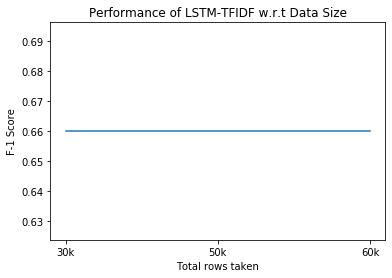

In [23]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt

names = ['30k', '50k', '60k']
values = [0.66, 0.66, 0.66]
plt.plot(names, values)
plt.xlabel('Total rows taken')
plt.ylabel('F-1 Score')
plt.title("Performance of LSTM-TFIDF w.r.t Data Size")

In [8]:
data[0]

[0.66, 0.66]